## Load data

In [9]:
import re

def extract_urls_from_data_file(file_path):
    with open(file_path, 'r') as file:
        data = file.read()

    urls = re.findall(r'GET (.*?) HTTP/1\.\d', data)
    
    urls_res = [url for url in urls if '?' in url if '=' in url]
    
    return urls_res

train_data_file_path = '/kaggle/input/dataset-csic2010/web-application-attacks-datasets-master/csic_2010/dataset_cisc_train_test/cisc_normalTraffic_train.txt'
train_urls = extract_urls_from_data_file(train_data_file_path)
train_urls = train_urls + extract_urls_from_data_file('/kaggle/input/dataset-csic2010/web-application-attacks-datasets-master/csic_2010/dataset_cisc_train_test/cisc_anomalousTraffic_test.txt')

## Preprocess data

In [10]:
import re
from urllib.parse import urlparse, parse_qs


def tokenize_url(url):
    # Decode URL and map all uppercase letters to lowercase
    url = url.lower()

    # Obtain the token sequence of URL structure
    parsed_url = urlparse(url)
    path = parsed_url.path
    query_params = parse_qs(parsed_url.query)

    path_tokens = path.split("/")[1:]
    url_tokens = ['<START>'] + path_tokens 

    for key, value in query_params.items():
        if len(value) > 0:
            url_tokens.append(key)
            url_tokens.append('<VAL>')
    url_tokens += ['<END>']
    
    # Obtain the token sequence of URL structure
    path = re.findall(r'http[s]?://([^/]+)(.*)', url)
    path_tokens = path[0][1].split('/')[1:]

    # Split the last token further to obtain query parameters
    query_param = path_tokens[-1].split('?')
    query_tokens = [query_param[0]]
    if len(query_param) > 1:
        # Split the query parameters by '&'
        query_params = query_param[1].split('&')

        for param in query_params:
            # Split each parameter by '=' to separate key and value
            param_tokens = param.split('=')

            # Replace numerical values with <NV> token and string values with <SV> token
            if len(param_tokens) == 2:
                key, value = param_tokens
                if value.isdigit():
                    param_tokens = [key, '<NV>']
                else:
                    param_tokens = [key, '<SV>']

            # Append the parameter tokens to the query_tokens list
            query_tokens.extend(param_tokens)

    # Insert <START> and <END> tokens
    query_tokens.insert(0, '<START>')
    query_tokens.append('<END>')

    return url_tokens, query_tokens

# Example URL
url = "http://example.com/path/to/query.php?id=1&email=one@me.com"

# Tokenize URL
path_tokens, query = tokenize_url(url)

# Print token sequences
print(path_tokens)
print(query)

['<START>', 'path', 'to', 'query.php', 'id', '<VAL>', 'email', '<VAL>', '<END>']
['<START>', 'query.php', 'id', '<NV>', 'email', '<SV>', '<END>']


In [11]:
for url in train_urls[:10]:
    print(url)

http://localhost:8080/tienda1/publico/registro.jsp?modo=registro&login=sikander&password=2eSCo63ENti2&nombre=Mario&apellidos=Zul+Ugartechea&email=cohn.of%40evasor.ch&dni=19064192K&direccion=Panama+128+5-B&ciudad=Ab%E1igar&cp=47511&provincia=Le%F3n&ntc=6796191867385507&B1=Registrar
http://localhost:8080/tienda1/publico/autenticar.jsp?modo=entrar&login=chuang&pwd=visionario&remember=on&B1=Entrar
http://localhost:8080/tienda1/publico/vaciar.jsp?B2=Vaciar+carrito
http://localhost:8080/tienda1/miembros/editar.jsp?modo=registro&login=chian&password=bal%F3n&nombre=Alarico&apellidos=Gelis&email=ruick_heasley4%4018horas.ro&dni=49449729M&direccion=C%2F+Pla+Des+Monestir+4%2C+2C&ciudad=Acebr%F3n%2C+El&cp=04858&provincia=Teruel&ntc=8320964749931174&B1=Registrar
http://localhost:8080/tienda1/publico/anadir.jsp?id=3&nombre=Queso+Manchego&precio=100&cantidad=25&B1=A%F1adir+al+carrito
http://localhost:8080/tienda1/publico/vaciar.jsp?B2=Vaciar+carrito
http://localhost:8080/tienda1/publico/pagar.jsp?modo

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, concatenate, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [13]:
print(len(train_urls))

train_label = [0]*len(extract_urls_from_data_file(train_data_file_path)) + [1]*len(extract_urls_from_data_file('/kaggle/input/dataset-csic2010/web-application-attacks-datasets-master/csic_2010/dataset_cisc_train_test/cisc_anomalousTraffic_test.txt'))
train_label = np.array(train_label)

17597


## Split data

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =  train_test_split(train_urls, train_label, test_size=0.2, random_state=42)

In [15]:
train_urls, X_test, y_train, y_test = train_test_split(train_urls, train_label, test_size=0.2, random_state=42)

## LSTM

## Train model

In [42]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, concatenate, Embedding, Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split

def tokenize_url(url):
    # Decode URL and map all uppercase letters to lowercase
    url = url.lower()

    # Obtain the token sequence of URL structure
    parsed_url = urlparse(url)
    path = parsed_url.path
    query_params = parse_qs(parsed_url.query)

    path_tokens = path.split("/")[1:]
    url_tokens = ['<START>'] + path_tokens 

    for key, value in query_params.items():
        if len(value) > 0:
            url_tokens.append(key)
            url_tokens.append('<VAL>')
    url_tokens += ['<END>']
    
    # Obtain the token sequence of URL structure
    path = re.findall(r'http[s]?://([^/]+)(.*)', url)
    path_tokens = path[0][1].split('/')[1:]

    # Split the last token further to obtain query parameters
    query_param = path_tokens[-1].split('?')
    query_tokens = [query_param[0]]
    if len(query_param) > 1:
        # Split the query parameters by '&'
        query_params = query_param[1].split('&')

        for param in query_params:
            # Split each parameter by '=' to separate key and value
            param_tokens = param.split('=')

#             # Replace numerical values with <NV> token and string values with <SV> token
#             if len(param_tokens) == 2:
#                 key, value = param_tokens
#                 if value.isdigit():
#                     param_tokens = [key, '<NV>']
#                 else:
#                     param_tokens = [key, '<SV>']

            # Append the parameter tokens to the query_tokens list
            query_tokens.extend(param_tokens)

    # Insert <START> and <END> tokens
#     query_tokens.insert(0, '<START>')
#     query_tokens.append('<END>')

    return url_tokens, query_tokens

def prepare_data(normal_urls):
    tokenized_urls = [tokenize_url(url) for url in normal_urls]
    wups_sequences = [wups for wups, _ in tokenized_urls]
    wqps_sequences = [wqps for _, wqps in tokenized_urls]
    return np.array(wups_sequences), np.array(wqps_sequences)

wups_sequences, wqps_sequences = prepare_data(train_urls + X_test)


# Train Word2Vec model
model = Word2Vec(sentences=wups_sequences + wqps_sequences, sg=1, vector_size=100, window=5, min_count=1)
# Get word vectors
word_vectors = model.wv

wups_sequences, wqps_sequences = prepare_data(train_urls)

# Create feature matrix
features_wups_sequences = [[word_vectors[word] for word in request] for request in wups_sequences]
features_wqps_sequences = [[word_vectors[word] for word in request] for request in wqps_sequences]

# Determine the maximum sequence length
max_sequence_length = max(len(request) for request in features_wups_sequences + features_wqps_sequences)
# Pad sequences to have the same length
padded_features_wups_sequences = pad_sequences(features_wups_sequences, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post', value=0.0)
padded_features_wqps_sequences = pad_sequences(features_wqps_sequences, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post', value=0.0)

# X_train_wups, X_test_wups, X_train_wqps, X_test_wqps, y_train, y_test = train_test_split(
#     padded_features_wups_sequences,
#     padded_features_wqps_sequences,
#     train_label,
#     test_size=0.2,
#     random_state=42
# )

X_train_wups = padded_features_wups_sequences
X_train_wqps = padded_features_wqps_sequences

# Define input layers
input_wups = Input(shape=(max_sequence_length, 100))
input_wqps = Input(shape=(max_sequence_length, 100))

# Define the LSTM models
url_path_rnn = LSTM(units=128, dropout=0.2, recurrent_dropout=0.2)(input_wups)
query_param_rnn = LSTM(units=128, dropout=0.2, recurrent_dropout=0.2)(input_wqps)

# Combine the LSTM outputs
combined_input = concatenate([url_path_rnn, query_param_rnn])

# MLP input dimension for fusion
mlp_input_dim = tf.keras.backend.int_shape(combined_input)[-1]

# Define the MLP for fusion
mlp_fusion = Dense(64, activation='relu')(combined_input)
mlp_fusion = Dropout(0.2)(mlp_fusion)
mlp_fusion = Dense(1, activation='sigmoid')(mlp_fusion)

# Create the combined model
combined_model = Model(inputs=[input_wups, input_wqps], outputs=mlp_fusion)

# Compile the model
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# callback
# early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)
# Train the model
hist = combined_model.fit(
    [X_train_wups,X_train_wqps],
    y_train,
    epochs=20,
    batch_size=16,
    validation_split=0.2
)

# Evaluate the model
# combined_model.evaluate(X_test, y_test)

/tmp/ipykernel_27/1403419389.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(wups_sequences), np.array(wqps_sequences)


Epoch 1/20
704/704 [==============================] - 181s 249ms/step - loss: 0.6891 - accuracy: 0.5389 - val_loss: 0.6802 - val_accuracy: 0.6186
Epoch 2/20
704/704 [==============================] - 179s 255ms/step - loss: 0.6166 - accuracy: 0.6276 - val_loss: 0.5275 - val_accuracy: 0.6570
Epoch 3/20
704/704 [==============================] - 179s 255ms/step - loss: 0.3879 - accuracy: 0.7929 - val_loss: 0.2642 - val_accuracy: 0.8722
Epoch 4/20
704/704 [==============================] - 172s 244ms/step - loss: 0.2222 - accuracy: 0.8978 - val_loss: 0.1943 - val_accuracy: 0.9180
Epoch 5/20
704/704 [==============================] - 173s 246ms/step - loss: 0.2013 - accuracy: 0.9148 - val_loss: 0.1542 - val_accuracy: 0.9332
Epoch 6/20
704/704 [==============================] - 174s 247ms/step - loss: 0.1856 - accuracy: 0.9237 - val_loss: 0.1451 - val_accuracy: 0.9464
Epoch 7/20
704/704 [==============================] - 174s 248ms/step - loss: 0.1577 - accuracy: 0.9393 - val_loss: 0.1593 -

## Evaluate

In [48]:
from sklearn.metrics import confusion_matrix
import pandas as pd

import time

start_time = time.time()
wups_sequences, wqps_sequences = prepare_data(X_test)
# Create feature matrix
features_wups_sequences = [[word_vectors_[word] for word in request] for request in wups_sequences]
features_wqps_sequences = [[word_vectors_[word] for word in request] for request in wqps_sequences]

# Determine the maximum sequence length
max_sequence_length = max(max_sequence_length,max(len(request) for request in features_wups_sequences + features_wqps_sequences))
# Pad sequences to have the same length
padded_features_wups_sequences = pad_sequences(features_wups_sequences, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post', value=0.0)
padded_features_wqps_sequences = pad_sequences(features_wqps_sequences, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post', value=0.0)

X_test_wups, X_test_wqps = padded_features_wups_sequences, padded_features_wqps_sequences

y_prob = combined_model.predict([X_test_wups, X_test_wqps])

print("Thời gian chạy là: --- %s giây ---" % (time.time() - start_time))

threshold = 0.5

y_pred = [1 if prob >= threshold else 0 for prob in y_prob]

cnf_matrix = confusion_matrix(y_test, y_pred)

TP = cnf_matrix[1, 1]
FP = cnf_matrix[0, 1]
TN = cnf_matrix[0, 0]
FN = cnf_matrix[1, 0]

print("Confusion Matrix:")
print(cnf_matrix)
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
ACC = (TP+TN) / (TP+FP+TN+FN)
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR,
                              'ACC': '%.4f' % ACC}, index=[0]).to_string(col_space=9, index=False)
# print(cnf_matrix)
print(other_metrics)

/tmp/ipykernel_27/1403419389.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(wups_sequences), np.array(wqps_sequences)


110/110 [==============================] - 3s 23ms/step
Thời gian chạy là: --- 5.676354169845581 giây ---
Confusion Matrix:
[[1576   18]
 [  60 1866]]
      TPR       FPR       FNR       ACC
   0.9688    0.0113    0.0312    0.9778


## Visualize model

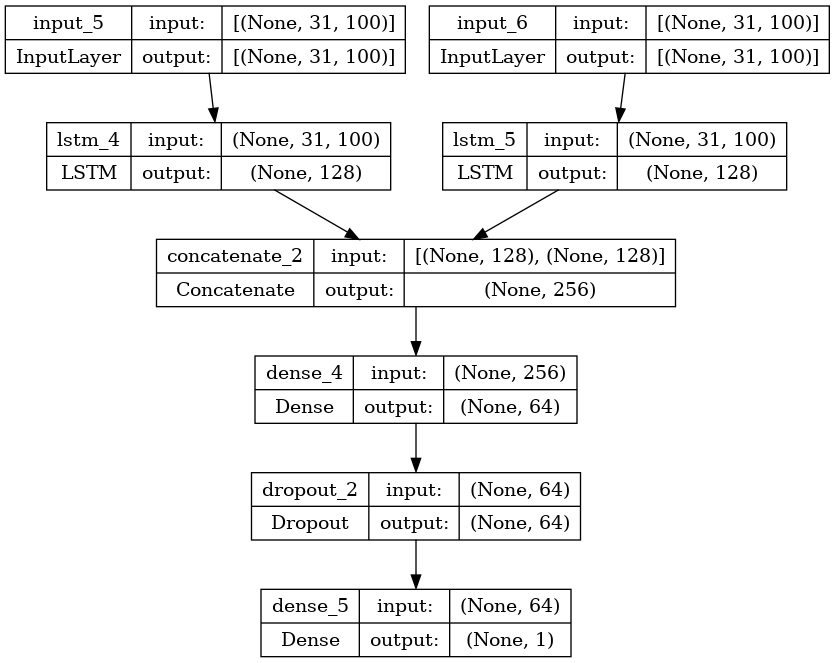

In [49]:
from tensorflow.keras.utils import plot_model
plot_model(combined_model, to_file='combined_model.png', show_shapes=True)

In [50]:
combined_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 31, 100)]    0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 31, 100)]    0           []                               
                                                                                                  
 lstm_4 (LSTM)                  (None, 128)          117248      ['input_5[0][0]']                
                                                                                                  
 lstm_5 (LSTM)                  (None, 128)          117248      ['input_6[0][0]']                
                                                                                            

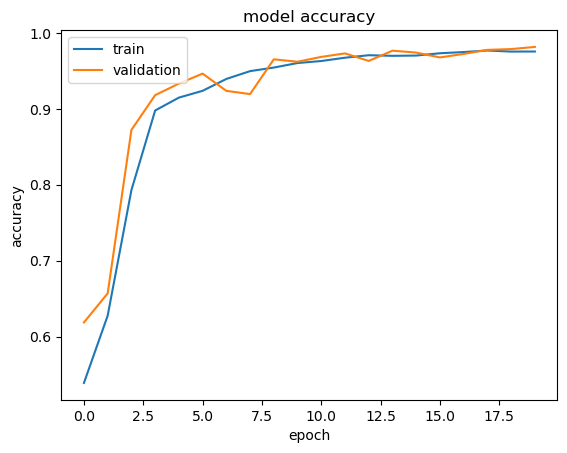

In [51]:
import matplotlib.pyplot as plt

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(hist)

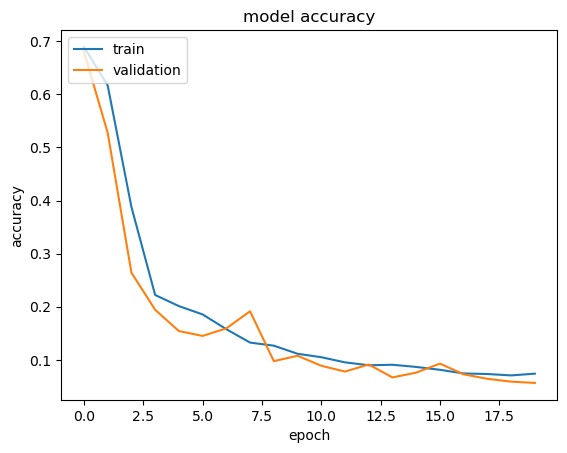

In [52]:
def plot_loss(hist):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_loss(hist)